<a href="https://colab.research.google.com/github/nguyenngocbinh/amex/blob/master/AMEX_%7C_EDA_%7C_NNB_PSI_KS_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import pandas as pd

In [4]:
! pip install -q kaggle

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nanabi","key":"11702931c704d28b51fb8c30ee14b089"}'}

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets list

In [ ]:
!kaggle competitions list

# Download data from kaggle

In [15]:
!kaggle competitions download -c amex-default-prediction 

100% 20.5G/20.5G [02:20<00:00, 218MB/s]
100% 20.5G/20.5G [02:20<00:00, 156MB/s]


In [ ]:
!kaggle datasets download -d raddar/amex-data-integer-dtypes-parquet-format

In [8]:
!kaggle datasets download -d cdeotte/amex-data-for-transformers-and-rnns

100% 9.30G/9.32G [01:25<00:00, 102MB/s]
100% 9.32G/9.32G [01:25<00:00, 118MB/s]


In [10]:
!kaggle datasets download -d cdeotte/amex-data-files

 39% 5.00M/12.9M [00:00<00:00, 40.2MB/s]
100% 12.9M/12.9M [00:00<00:00, 61.6MB/s]


In [ ]:
!unzip '/content/amex-default-prediction.zip'

Archive:  /content/amex-default-prediction.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: train_data.csv          

In [ ]:
!unzip '/content/amex-data-integer-dtypes-parquet-format.zip'

In [11]:
!unzip '/content/amex-data-files.zip'

Archive:  /content/amex-data-files.zip
  inflating: test_customer_hashes.pqt  
  inflating: train_customer_hashes.pqt  


In [ ]:
!unzip '/content/drive/MyDrive/amex/amex-data-for-transformers-and-rnns.zip'

# EDA

In [ ]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools
import pyarrow.parquet as pq
from scipy import stats

## Check stable columns

### Characteristic Stability Index (CSI)

The Characteristic Stability Index (CSI) is used to evaluate the stability or drift of each feature so that we can find the problematic one. As PSI is concerned with the effects of the population drift on the model’s predictions, the CSI is concerned with understanding how the feature distributions have changed

- CSI < 0.1 = The characteristic hasn’t changed, and we can use to train the model
- 0.1 ≤ CS1 < 0.2 = The characteristic has slightly changed, and it is advisable to evaluate the impacts of these changes
- CSI ≥ 0.2 = The changes in characteristic are significant, and the model should not be used the characteristic in model.



In [ ]:
def ks_test():
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    binary_features = ['B_31', 'D_87']

    cat_features = cat_features + binary_features
    statistic = []
    pvalue = []    

    num_features = list(set(train.columns) - set(cat_features))
    # num_features = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)    
    for i, name in enumerate(num_features):
        statistic_, pvalue_ = stats.ks_2samp(train[name], test[name])
        statistic.append(statistic_)
        pvalue.append(pvalue_) 
    return pd.DataFrame({'name':num_features, 'ks':statistic, 'pvalue':pvalue})

def psi(var):    
    x = train.groupby(var).size().to_frame()
    x.reset_index(inplace = True)        
    y = test.groupby(var).size().to_frame()
    y.reset_index(inplace = True)    
    psi_tbl = x.merge(y, how = 'inner', on = var)
    psi_tbl['perc_train'] = psi_tbl['0_x']/sum(psi_tbl['0_x'])
    psi_tbl['perc_test']= psi_tbl['0_y']/sum(psi_tbl['0_y'])
    psi_tbl['psi_sub']= (psi_tbl['perc_train']-psi_tbl['perc_test']) * np.log(psi_tbl['perc_train']/psi_tbl['perc_test'])    
    return sum(psi_tbl['psi_sub'])

def psi_test():
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    binary_features = ['B_31', 'D_87']
    cat_features = cat_features + binary_features
    psi_out = []
    for i, name in enumerate(cat_features):        
        psi_out.append(psi(name))                
    return pd.DataFrame({'name':cat_features, 'psi':psi_out})

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/amex/train.parquet')
test = pd.read_parquet('/content/drive/MyDrive/amex/test.parquet')

In [ ]:
psi_table = psi_test().sort_values('psi')
psi_table

,name,psi
11,B_31,0.000048
12,D_87,0.000086
0,B_30,0.000444
9,D_66,0.000495
2,D_114,0.002055
3,D_116,0.002946
10,D_68,0.003286
4,D_117,0.005318
8,D_64,0.006509
7,D_63,0.006725


In [ ]:
ks_table = ks_test().sort_values('ks')
ks_table.tail(20)

,name,ks,pvalue
29,R_27,0.035121,0.0
87,D_77,0.035953,0.0
126,S_22,0.036177,0.0
52,S_7,0.037407,0.0
68,S_8,0.037452,0.0
23,D_56,0.038018,0.0
103,D_55,0.040623,0.0
17,B_8,0.044764,0.0
93,D_45,0.053554,0.0
118,S_27,0.063479,0.0


# Feature engineering

In [ ]:
def features_info():
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]

    binary_features = ['B_31', 'D_87']

    cat_features = cat_features + binary_features
    schema = pq.read_schema('/content/drive/MyDrive/amex/train.parquet', memory_map=True)
    features = list(schema.names)
    features = [col for col in features if col not in ['customer_ID', 'S_2']]
    num_features = [col for col in features if col not in cat_features]
    rm_var_by_ks = ['R_1', 'S_11', 'D_59', 'B_29', 'S_9']
    return features, cat_features, num_features, rm_var_by_ks


def preprocess_train_data(nlag):
    features, cat_features, num_features, rm_var_by_ks = features_info()
    num_features = list(set(num_features) - set(rm_var_by_ks))
    print('Starting training feature engineer...')
    train = pd.read_parquet('/content/drive/MyDrive/amex/train.parquet')
    train_num_agg = train.groupby("customer_ID").tail(nlag).groupby(
        "customer_ID")[num_features].agg({'mean', 'std', 'max', 'min', 'last'})
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace=True)    
    # category variable
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(
        ['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace=True)
    train_labels = pd.read_csv('/content/drive/MyDrive/amex/train_labels.csv')
    train = train_num_agg.merge(train_cat_agg, how='inner',
                                on='customer_ID').merge(train_labels,
                                                        how='inner',
                                                        on='customer_ID')
    gc.collect()
    print('Finished train feature engineer!')
    return train


def preprocess_test_data():
    features, cat_features, num_features, rm_var_by_ks = features_info()
    num_features = list(set(num_features) - set(rm_var_by_ks))
    gc.collect()
    test = pd.read_parquet('/content/drive/MyDrive/amex/test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID").tail(3).groupby(
        "customer_ID")[num_features].agg(['mean', 'std', 'max', 'min', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace=True)
    # category variable
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(
        ['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace=True)
    test = test_num_agg.merge(test_cat_agg, how='inner', on='customer_ID')
    gc.collect()
    print('Finished test feature engineer!')
    return test

In [ ]:
preprocess_train_data(nlag = 13).to_parquet('/content/drive/MyDrive/amex/train_data_fe.parquet')

Starting training feature engineer...
Finished train feature engineer!


In [ ]:
preprocess_test_data().to_parquet('/content/drive/MyDrive/amex/test_data_fe.parquet')

Starting test feature engineer...
Finished test feature engineer!


In [ ]:
preprocess_train_data(nlag = 6).to_parquet('/content/drive/MyDrive/amex/train_data_lag6_fe.parquet')

Starting training feature engineer...
Finished train feature engineer!


In [ ]:
preprocess_train_data(nlag = 3).to_parquet('/content/drive/MyDrive/amex/train_data_lag6_fe.parquet')

Starting training feature engineer...
Finished train feature engineer!


# Modelling

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations
import pyarrow.parquet as pq
# ====================================================
# Configurations
# ====================================================
class CFG:
    input_dir = '/content/drive/MyDrive/amex/'
    seed = 108
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_data_fe.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_data_fe.parquet')
    return train, test

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# Output include:
# - eval_name
# - eval_result
# - is_higher_better
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

# ====================================================
# Train & Evaluate
# ====================================================
def train_and_evaluate(train, test):
    features, cat_features, num_features, rm_var_by_ks = features_info()

    # Label encode categorical features        
    cat_features = [f"{cf}_last" for cf in cat_features]
    
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': CFG.metric,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        'num_leaves': 108,
        'learning_rate': 0.0158,
        'feature_fraction': 0.22,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 42
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 9000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 1500,
            verbose_eval = 500,            
            feval = lgb_amex_metric
            )
        
        # Save best model
        joblib.dump(model, f'/content/drive/MyDrive/amex/Models/lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'/content/drive/MyDrive/amex/OOF/oof_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'/content/drive/MyDrive/amex/Predictions/test_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    print('Finished!')
    
seed_everything(CFG.seed)
train, test = read_data()
train_and_evaluate(train, test)

  0%|          | 0/870 [00:00<?, ?it/s]

tcmalloc: large alloc 1841848320 bytes == 0xce188000 @  0x7faa96a191e7 0x7faa88bb046e 0x7faa88c00c7b 0x7faa88c00d18 0x7faa88c933a9 0x7faa88c95ab5 0x4d3969 0x512147 0x549576 0x4bcb19 0x7faa88bedef7 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x511e2c 0x549e0e 0x593fce 0x511e2c 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f
tcmalloc: large alloc 1327759360 bytes == 0x163288000 @  0x7faa96a191e7 0x7faa88bb046e 0x7faa88c00c7b 0x7faa88c00d18 0x7faa88c933a9 0x7faa88c95ab5 0x4d3969 0x512147 0x549576 0x4bcb19 0x7faa88bedef7 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x511e2c 0x549e0e 0x593fce 0x511e2c 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x548ae9 0x51566f
tcmalloc: large alloc 1834450944 bytes == 0x22893c000 @  0x7faa96a191e7 0x7faa88bb046e 0x7faa88c00c7b 0x7faa88c00d18 0x7faa88c933a9 0x7faa88c95ab5 0x4d3969 0x512147 0x549576 0x4bcb19 0x7faa88bedef7 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x

 
--------------------------------------------------
Training fold 0 with 1149 features...


tcmalloc: large alloc 3374661632 bytes == 0x2ed624000 @  0x7faa96a191e7 0x7faa88bb046e 0x7faa88c00c7b 0x7faa88c0135f 0x7faa88ca3103 0x593835 0x548c51 0x5127f1 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x548ae9 0x5127f1 0x59a257 0x570bf0 0x531c8b 0x511ee1 0x549e0e 0x593fce 0x5118f8 0x549e0e 0x593fce 0x548ae9 0x5127f1 0x593dd7 0x511e2c 0x549e0e 0x4bca8a
tcmalloc: large alloc 3374661632 bytes == 0x3b7314000 @  0x7faa96a191e7 0x7faa88bb046e 0x7faa88c00c7b 0x7faa88c00d97 0x7faa88bfa4a5 0x7faa88ccb29c 0x7faa88c98dd1 0x59b1b0 0x515655 0x593dd7 0x511e2c 0x549e0e 0x593fce 0x548ae9 0x5127f1 0x593dd7 0x511e2c 0x549e0e 0x4bca8a 0x532b86 0x594a96 0x548cc1 0x5127f1 0x549576 0x593fce 0x548ae9 0x5127f1 0x593dd7 0x5118f8 0x549576 0x604173


[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.032297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191295
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 1143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.278214	training's amex_metric: 0.78883	valid_1's binary_logloss: 0.283223	valid_1's amex_metric: 0.773277


# Test lightgbm GPU version

In [ ]:
!pip install lightgbm==3.3.1 --install-option=--gpu # 2.2.3

In [ ]:
def read_sample_data():
    train = pd.read_parquet('/content/drive/MyDrive/amex/train_data_fe.parquet').groupby(
        'target', group_keys=False).apply(lambda x: x.sample(frac=0.1))  
    test = pd.read_parquet('/content/drive/MyDrive/amex/test_data_fe.parquet').sample(
        frac=0.1, replace=True, random_state=1)

    return train, test

train, test = read_sample_data()

# Modelling

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

# ====================================================
# Configurations
# ====================================================
class CFG:
    input_dir = '/content/drive/MyDrive/amex/'
    seed = 108
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
def read_data():
    #train = pd.read_parquet(
    #    CFG.input_dir + 'train_data_fe.parquet').groupby(
    #        'target', group_keys=False).apply(lambda x: x.sample(frac=0.8))  
         
    #train_lag6 = pd.read_parquet(
    #    CFG.input_dir + 'train_data_fe.parquet').groupby(
    #        'target', group_keys=False).apply(lambda x: x.sample(frac=0.3)) 
 
    #train = pd.concat([train_lag13, train_lag6])

    train = pd.read_parquet(CFG.input_dir + 'train_data_fe.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_data_fe.parquet')
    return train, test

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# Output include:
# - eval_name
# - eval_result
# - is_higher_better
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

# ====================================================
# Train & Evaluate
# ====================================================
def train_and_evaluate(train, test):
    features, cat_features, num_features, rm_var_by_ks = features_info()

    # Label encode categorical features        
    cat_features = [f"{cf}_last" for cf in cat_features]
    
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': CFG.metric,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        'num_leaves': 108,
        'learning_rate': 0.0158,
        'feature_fraction': 0.22,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 42,
        'max_bin':63,
        'device' : 'gpu'
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 9000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 1500,
            verbose_eval = 500,            
            feval = lgb_amex_metric
            )
        
        # Save best model
        joblib.dump(model, f'/content/drive/MyDrive/amex/Models/lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'/content/drive/MyDrive/amex/OOF/oof_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'/content/drive/MyDrive/amex/Predictions/test_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    print('Finished!')
    
seed_everything(CFG.seed)
train, test = read_data()
train_and_evaluate(train, test)

  0%|          | 0/870 [00:00<?, ?it/s]

 
--------------------------------------------------
Training fold 0 with 1149 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55868
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 1143
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 619 dense feature groups (217.08 MB) transferred to GPU in 0.128998 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.278605	training's amex_metric: 0.787885	valid_1's binary_logloss: 0.283354	valid_1's amex_metric: 0.772838
[1000]	training's binary_logloss: 0.220068

KeyboardInterrupt: ignored

In [ ]:
!pip install session_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=5099a851f622bbe4be00ede41694810c3af7d5381e7df76517c1b8ed2b8e7214
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [ ]:
import session_info
import lightgbm as lgb
session_info.show()

# Submit


In [ ]:
sub = pd.read_csv('../input/amex-sub/test_lgbm_baseline_5fold_seed_blend.csv')
sub.to_csv('test_lgbm_baseline_5fold_seed_blend.csv', index = False)

In [ ]:
!kaggle competitions submit -c amex-default-prediction -f /content/drive/MyDrive/amex/Predictions/test_lgbm_dart_baseline_5fold_seed42_3monthlag.csv -m 3mth_lag

100% 75.2M/75.2M [00:02<00:00, 28.2MB/s]
Successfully submitted to American Express - Default Prediction

# Calibration

In [ ]:
preds = pd.read_csv('/content/drive/MyDrive/amex/OOF/oof_lgbm_dart_baseline_5fold_seed42.csv')

In [ ]:
preds.head()

,customer_ID,target,prediction
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000446
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000879
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.001134
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.004075
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.001206


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

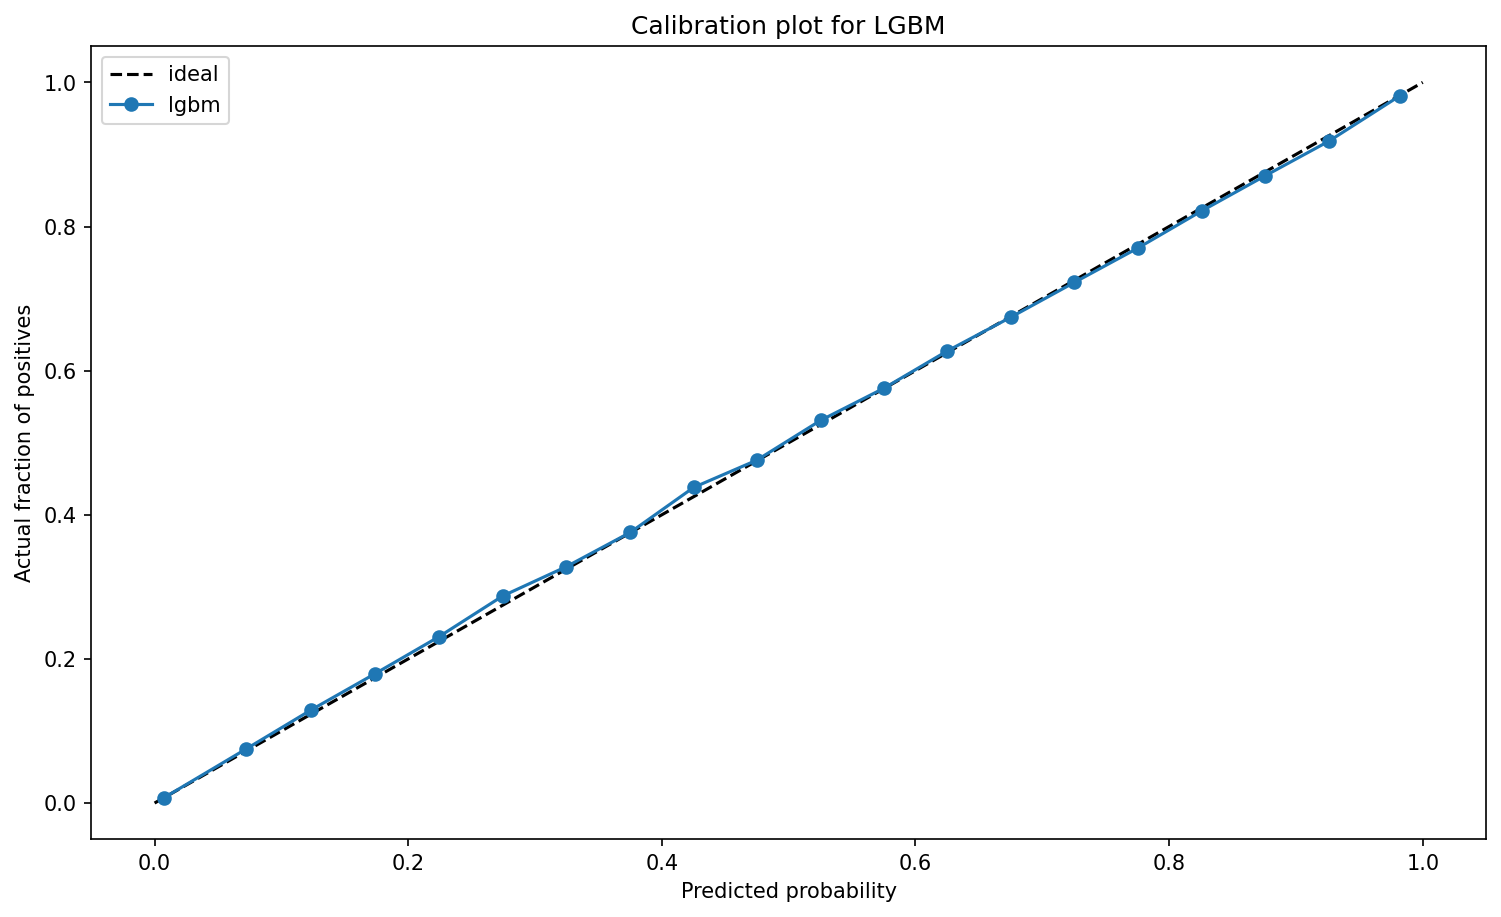

In [ ]:
# creating a dataframe of target and probabilities
prob_df_lgbm = preds

# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_lgbm.loc[:,'prob_bin'] = np.digitize(prob_df_lgbm['prediction'], bins)
prob_df_lgbm.loc[:,'prob_bin_val'] = prob_df_lgbm['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

# opening figure
plt.figure(figsize=(12,7), dpi=150)

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for lgbm
calibration_y = prob_df_lgbm.groupby('prob_bin_val')['target'].mean()
calibration_x = prob_df_lgbm.groupby('prob_bin_val')['prediction'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='lgbm')

# legend and titles
plt.title('Calibration plot for LGBM')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()

# Optuna 

In [ ]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO for pycaret
    !pip install tune-sklearn
    !pip install optuna # hyperopt is already in colab

    # gpu version of lightgbm for pycaret
    !pip uninstall lightgbm -y
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    # regular pycaret without gpu 
    !pip install pycaret-nightly[full]

    # ipywidget
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    print('Environment: Google Colab')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib

from tqdm import tqdm_notebook as tqdm

SEED = 108
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret 

%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy     : 1.19.5
matplotlib: 3.5.2
seaborn   : 0.11.2
pandas    : 1.3.5
pycaret   : 2.3.10
sys       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
joblib    : 1.1.0



In [ ]:
!pip install pycaret --user

In [ ]:
!pip install markupsafe==2.0.1

In [ ]:
!pip install Jinja2==3.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.15.1 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0, but you have tornado 6.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, 

In [ ]:
import pycaret
import pycaret.classification as pyc

ImportError: ignored

In [ ]:
USE_GPU = False
if ENV_COLAB:
    USE_GPU = True

In [ ]:
def read_sample_data():
    train = pd.read_parquet('/content/drive/MyDrive/amex/train_data_fe.parquet').groupby(
        'target', group_keys=False).apply(lambda x: x.sample(frac=0.1))  
    test = pd.read_parquet('/content/drive/MyDrive/amex/test_data_fe.parquet').sample(
        frac=0.1, replace=True, random_state=1)

    return train, test

train, test = read_sample_data()

In [ ]:
def features_info():
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]

    binary_features = ['B_31', 'D_87']

    cat_features = cat_features + binary_features
    schema = pq.read_schema('/content/drive/MyDrive/amex/train.parquet', memory_map=True)
    features = list(schema.names)
    features = [col for col in features if col not in ['customer_ID', 'S_2']]
    num_features = [col for col in features if col not in cat_features]
    rm_var_by_ks = ['R_1', 'S_11', 'D_59', 'B_29', 'S_9']
    return features, cat_features, num_features, rm_var_by_ks

In [ ]:
exp = pyc.setup(train,
                target = 'target',
                train_size = 0.8,
                session_id = 108,
                use_gpu = USE_GPU,
                preprocess = True,
                categorical_features = None,
                ordinal_features = None,
                high_cardinality_features = None,
                numeric_features = None,
                date_features = None,
                ignore_features = None,
                normalize = False,
                data_split_stratify = True,
                silent=True,
                profile=False,
                log_experiment=False
                )

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:19:52
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


tcmalloc: large alloc 5423251456 bytes == 0xaf278000 @  0x7f8acc1b8001 0x7f8abe34d54f 0x7f8abe39db58 0x7f8abe3a1b17 0x7f8abe440203 0x593835 0x548c51 0x5127f1 0x593dd7 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x4bcb19 0x59c019 0x595ef6 0x5134a6 0x549576 0x4bca8a 0x5134a6 0x549576 0x4bca8a 0x532e76 0x595ef6 0x5134a6 0x549576 0x4bca8a 0x59c019
tcmalloc: large alloc 5423251456 bytes == 0x1f2e7c000 @  0x7f8acc1b61e7 0x7f8abe34d46e 0x7f8abe39dc7b 0x7f8abe39dd97 0x7f8abe3974a5 0x7f8abe434eab 0x59b1b0 0x515655 0x549576 0x593fce 0x548ae9 0x5127f1 0x593dd7 0x511e2c 0x549576 0x4bca8a 0x5134a6 0x549e0e 0x593fce 0x548ae9 0x5127f1 0x549576 0x4bcb19 0x59c019 0x595ef6 0x5134a6 0x549576 0x4bca8a 0x5134a6 0x549576 0x4bca8a
tcmalloc: large alloc 5512822784 bytes == 0x336280000 @  0x7f8acc1b61e7 0x7f8abe34d46e 0x7f8abe39dc7b 0x7f8abe39dd18 0x7f8abe445010 0x7f8abe44573c 0x7f8abe44585d 0x4bc4ab 0x7f8abe38aef7 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x51566f 0x4bc98a 0x7f8abe38aef7

In [ ]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [ ]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

pyc.add_metric('amex_metric', 'amex_metric', amex_metric, greater_is_better=False)

AttributeError: ignored

In [ ]:
def compare_new_models(name,desc,mean_row,ofile,
                       df_eval=None,sort='Recall',show=True):
    """Create dataframe from output of pycaret new model.
    Parameters
    -----------
    name: str
        Name of the model. eg. xgboost
    desc: str
        Description of the model. e.g tuned,calibrated
    mean_arr: np.ndarray
        The mean row.
        e.g. 
        df_res = pyc.pull()
        mean_row = df_res.loc['Mean']
    ofile: str
        Output file name. e.g. 'pycaret_df_eval_lr.csv'
    df_eval: Pandas Dataframe
        Template pandas dataframe
    sort: str
       One of following string: Accuracy, AUC, Recall, Precision, F1, Kappa

    Returns:
       Pandas Dataframe.
    """
    
    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'Accuracy':[],
                                'AUC':[],
                                'Recall':[],
                                'Precision':[],
                                'F1':[],
                                'Kappa':[],
                                'MCC': [],
                                'LogLoss': []
                               })

    acc,auc,rec,pre,f1,kap,mcc,logloss = mean_row
    row = [name,desc,acc,auc,rec,pre,f1,kap,mcc,logloss]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates()\
                     .sort_values(sort,ascending=False)
    df_eval.index = range(len(df_eval))
    
    df_style = (df_eval.style.apply(lambda ser:
                ['background: tomato'
                 if ser.name == sort else ''
                 for _ in ser]))

    if show:
        display(df_style)

    # save the data
    df_eval.to_csv(ofile)
    
    return df_eval

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO for pycaret
    !pip install tune-sklearn
    !pip install optuna # hyperopt is already in colab

    # gpu version of lightgbm for pycaret
    !pip uninstall lightgbm -y
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    # regular pycaret without gpu 
    !pip install pycaret-nightly[full]

    # ipywidget
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    print('Environment: Google Colab')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret

%load_ext watermark
%watermark -iv

IPython   : 7.34.0
numpy     : 1.19.5
pycaret   : 2.3.10
sys       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
joblib    : 1.1.0
matplotlib: 3.5.2
seaborn   : 0.11.2
pandas    : 1.3.5



# Time Series GRU TensorFlow Starter Notebook
In this notebook we present starter code for a time series GRU model and starter code for processing Kaggle's 50GB CSV files into multiple saved NumPy files. Using a time series GRU allows us to use all the provided customer data and not just the customer's last data point. We published plots of time series data [here][1]. In this notebook we
* Processes the train data from dataframes into 3D NumPy array of dimensions `num_of_customers x 13 x 188`
* Save processed arrays as multiple NumPy files on disk
* Next we build and train a GRU from the multiple files on disk
* We compute validation score and achieve 0.787
* Finally we process and save test data, infer test, and create a submission

It is important to note that you **do not need** to process the train and test files every time you run this notebook. Only process the data again when you engineer new features. Otherwise, upload your saved NumPy arrays to a Kaggle dataset (or use my Kaggle dataset [here][2]). Then as you customize and improve your GRU model, set the variable `PROCESS_DATA = False` and `PATH_TO_DATA = [the path to your kaggle dataset]`.

To view time series EDA which can help give you intuition about feature engineering and improving model architecture, see my other notebook [here][1]. Note in the code below, we partition the GPU into 8GB for RAPIDS (feature engineering) and 8GB for TensorFlow (model build and train).

[1]: https://www.kaggle.com/cdeotte/time-series-eda
[2]: https://www.kaggle.com/datasets/cdeotte/amex-data-for-transformers-and-rnns

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import tensorflow.keras.backend as K
print('Using TensorFlow version',tf.__version__)

# RESTRICT TENSORFLOW TO 8GB OF GPU RAM
# SO THAT WE HAVE 8GB RAM FOR RAPIDS
LIMIT = 8
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  except RuntimeError as e:
    print(e)
print('We will restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('then RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

Using TensorFlow version 2.8.2
We will restrict TensorFlow to max 8GB GPU RAM
then RAPIDS can use 8GB GPU RAM


# Process Train Data
We process both train and test data in chunks. We split train data into 10 parts and process each part separately and save to disk. We split test into 20 parts. This allows us to avoid memory errors during processing. We can also perform processing on GPU which is faster than CPU. Discussions about data preprocessing are [here][1] and [here][2]

[1]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327828
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054

In [13]:
# LOADING JUST FIRST COLUMN OF TRAIN OR TEST IS SLOW
# INSTEAD YOU CAN LOAD FIRST COLUMN FROM MY DATASET
# OTHERWISE SET VARIABLE TO NONE TO LOAD FROM KAGGLE'S ORIGINAL DATAFRAME
PATH_TO_CUSTOMER_HASHES = '/content/drive/MyDrive/amex/'

# AFTER PROCESSING DATA ONCE, UPLOAD TO KAGGLE DATASET
# THEN SET VARIABLE BELOW TO FALSE
# AND ATTACH DATASET TO NOTEBOOK AND PUT PATH TO DATASET BELOW
PROCESS_DATA = True
PATH_TO_DATA = '/content/drive/MyDrive/amex/amex-data-for-transformers-and-rnns/data/'
#PATH_TO_DATA = '../input/amex-data-for-transformers-and-rnns/data/'

# AFTER TRAINING MODEL, UPLOAD TO KAGGLE DATASET
# THEN SET VARIABLE BELOW TO FALSE
# AND ATTACH DATASET TO NOTEBOOK AND PUT PATH TO DATASET BELOW
TRAIN_MODEL = True
PATH_TO_MODEL = '/content/drive/MyDrive/amex/RNNS/model/'
#PATH_TO_MODEL = '../input/amex-data-for-transformers-and-rnns/model/'

INFER_TEST = True

In [14]:
import cupy, cudf # GPU LIBRARIES
import numpy as np, pandas as pd # CPU LIBRARIES
import matplotlib.pyplot as plt, gc

if PROCESS_DATA:
    # LOAD TARGETS
    targets = cudf.read_csv('/content/drive/MyDrive/amex/train_labels.csv')
    targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    print(f'There are {targets.shape[0]} train targets')
    
    # GET TRAIN COLUMN NAMES
    train = cudf.read_csv('../input/amex-default-prediction/train_data.csv', nrows=1)
    T_COLS = train.columns
    print(f'There are {len(T_COLS)} train dataframe columns')
    
    # GET TRAIN CUSTOMER NAMES (use pandas to avoid memory error)
    if PATH_TO_CUSTOMER_HASHES:
        train = cudf.read_parquet(f'{PATH_TO_CUSTOMER_HASHES}train_customer_hashes.pqt')
    else:
        train = pd.read_csv('/raid/Kaggle/amex/train_data.csv', usecols=['customer_ID'])
        train['customer_ID'] = train['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    customers = train.drop_duplicates().sort_index().values.flatten()

    print(f'There are {len(customers)} unique customers in train.')

ModuleNotFoundError: ignored

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE FILE
def get_rows(customers, train, NUM_FILES = 10, verbose = ''):
    chunk = len(customers)//NUM_FILES
    if verbose != '':
        print(f'We will split {verbose} data into {NUM_FILES} separate files.')
        print(f'There will be {chunk} customers in each file (except the last file).')
        print('Below are number of rows in each file:')
    rows = []

    for k in range(NUM_FILES):
        if k==NUM_FILES-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = train.loc[train.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows

if PROCESS_DATA:
    NUM_FILES = 10
    rows = get_rows(customers, train, NUM_FILES = NUM_FILES, verbose = 'train')

# Preprocess and Feature Engineering
The function below processes the data. Discussions describing the process are [here][1] and [here][2]. Currently the code below uses [RAPIDS][3] and GPU to
* Reduces memory usage of customer_ID column by converting to int64
* Reduces memory usage of date time column (then deletes the column).
* We fill NANs
* Label encodes the categorical columns
* We reduce memory usage dtypes of columns
* Converts every customer into a 3D array with sequence length 13 and feature length 188

To improve this model, try adding new feautures. The columns have been rearanged to have the 11 categorical features first. This makes building the TensorFlow model later easier. We can also try adding Standard Scaler. Currently the data is being used without scaling from the original Kaggle train data. 

[1]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327828
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054
[3]: https://rapids.ai/

In [ ]:
def feature_engineer(train, PAD_CUSTOMER_TO_13_ROWS = True, targets = None):
        
    # REDUCE STRING COLUMNS 
    # from 64 bytes to 8 bytes, and 10 bytes to 3 bytes respectively
    train['customer_ID'] = train['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    train.S_2 = cudf.to_datetime( train.S_2 )
    train['year'] = (train.S_2.dt.year-2000).astype('int8')
    train['month'] = (train.S_2.dt.month).astype('int8')
    train['day'] = (train.S_2.dt.day).astype('int8')
    del train['S_2']
        
    # LABEL ENCODE CAT COLUMNS (and reduce to 1 byte)
    # with 0: padding, 1: nan, 2,3,4,etc: values
    d_63_map = {'CL':2, 'CO':3, 'CR':4, 'XL':5, 'XM':6, 'XZ':7}
    train['D_63'] = train.D_63.map(d_63_map).fillna(1).astype('int8')

    d_64_map = {'-1':2,'O':3, 'R':4, 'U':5}
    train['D_64'] = train.D_64.map(d_64_map).fillna(1).astype('int8')
    
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
    OFFSETS = [2,1,2,2,3,2,3,2,2] #2 minus minimal value in full train csv
    # then 0 will be padding, 1 will be NAN, 2,3,4,etc will be values
    for c,s in zip(CATS,OFFSETS):
        train[c] = train[c] + s
        train[c] = train[c].fillna(1).astype('int8')
    CATS += ['D_63','D_64']
    
    # ADD NEW FEATURES HERE
    # EXAMPLE: train['feature_189'] = etc etc etc
    # EXAMPLE: train['feature_190'] = etc etc etc
    # IF CATEGORICAL, THEN ADD TO CATS WITH: CATS += ['feaure_190'] etc etc etc
    
    # REDUCE MEMORY DTYPE
    SKIP = ['customer_ID','year','month','day']
    for c in train.columns:
        if c in SKIP: continue
        if str( train[c].dtype )=='int64':
            train[c] = train[c].astype('int32')
        if str( train[c].dtype )=='float64':
            train[c] = train[c].astype('float32')
            
    # PAD ROWS SO EACH CUSTOMER HAS 13 ROWS
    if PAD_CUSTOMER_TO_13_ROWS:
        tmp = train[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
        more = cupy.array([],dtype='int64') 
        for j in range(1,13):
            i = tmp.loc[tmp==j].index.values
            more = cupy.concatenate([more,cupy.repeat(i,13-j)])
        df = train.iloc[:len(more)].copy().fillna(0)
        df = df * 0 - 1 #pad numerical columns with -1
        df[CATS] = (df[CATS] * 0).astype('int8') #pad categorical columns with 0
        df['customer_ID'] = more
        train = cudf.concat([train,df],axis=0,ignore_index=True)
        
    # ADD TARGETS (and reduce to 1 byte)
    if targets is not None:
        train = train.merge(targets,on='customer_ID',how='left')
        train.target = train.target.astype('int8')
        
    # FILL NAN
    train = train.fillna(-0.5) #this applies to numerical columns
    
    # SORT BY CUSTOMER THEN DATE
    train = train.sort_values(['customer_ID','year','month','day']).reset_index(drop=True)
    train = train.drop(['year','month','day'],axis=1)
    
    # REARRANGE COLUMNS WITH 11 CATS FIRST
    COLS = list(train.columns[1:])
    COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
    train = train[COLS]
    
    return train

In [ ]:
if PROCESS_DATA:
    # CREATE PROCESSED TRAIN FILES AND SAVE TO DISK        
    for k in range(NUM_FILES):

        # READ CHUNK OF TRAIN CSV FILE
        skip = int(np.sum( rows[:k] ) + 1) #the plus one is for skipping header
        train = cudf.read_csv('../input/amex-default-prediction/train_data.csv', nrows=rows[k], 
                              skiprows=skip, header=None, names=T_COLS)

        # FEATURE ENGINEER DATAFRAME
        train = feature_engineer(train, targets = targets)

        # SAVE FILES
        print(f'Train_File_{k+1} has {train.customer_ID.nunique()} customers and shape',train.shape)
        tar = train[['customer_ID','target']].drop_duplicates().sort_index()
        if not os.path.exists(PATH_TO_DATA): os.makedirs(PATH_TO_DATA)
        tar.to_parquet(f'{PATH_TO_DATA}targets_{k+1}.pqt',index=False)
        data = train.iloc[:,1:-1].values.reshape((-1,13,188))
        cupy.save(f'{PATH_TO_DATA}data_{k+1}',data.astype('float32'))

    # CLEAN MEMORY
    del train, tar, data
    del targets
    gc.collect()

In [ ]:
# SIMPLE GRU MODEL
def build_model():
    
    # INPUT - FIRST 11 COLUMNS ARE CAT, NEXT 177 ARE NUMERIC
    inp = tf.keras.Input(shape=(13,188))
    embeddings = []
    for k in range(11):
        emb = tf.keras.layers.Embedding(10,4)
        embeddings.append( emb(inp[:,:,k]) )
    x = tf.keras.layers.Concatenate()([inp[:,:,11:]]+embeddings)
    
    # SIMPLE RNN BACKBONE
    x = tf.keras.layers.GRU(units=128, return_sequences=False)(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    
    # OUTPUT
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer = opt)
    
    return model

In [ ]:
# CUSTOM LEARNING SCHEUDLE
def lrfn(epoch):
    lr = [1e-3]*5 + [1e-4]*2 + [1e-5]*1
    return lr[epoch]
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

# Competition Metric Code
The code below is from Konstantin Yakovlev's discussion post [here][1]

[1]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534

In [ ]:
# COMPETITION METRIC FROM Konstantin Yakovlev
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# Train Model
We train 5 folds for 8 epochs each. We save the 5 fold models for test inference later. If you only want to infer without training, then set variable `TRAIN_MODEL = False` in the beginning of this notebook.

In [ ]:
if TRAIN_MODEL:
    # SAVE TRUE AND OOF
    true = np.array([])
    oof = np.array([])
    VERBOSE = 2 # use 1 for interactive 

    for fold in range(5):

        # INDICES OF TRAIN AND VALID FOLDS
        valid_idx = [2*fold+1, 2*fold+2]
        train_idx = [x for x in [1,2,3,4,5,6,7,8,9,10] if x not in valid_idx]

        print('#'*25)
        print(f'### Fold {fold+1} with valid files', valid_idx)

        # READ TRAIN DATA FROM DISK
        X_train = []; y_train = []
        for k in train_idx:
            X_train.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
            y_train.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
        X_train = np.concatenate(X_train,axis=0)
        y_train = pd.concat(y_train).target.values
        print('### Training data shapes', X_train.shape, y_train.shape)

        # READ VALID DATA FROM DISK
        X_valid = []; y_valid = []
        for k in valid_idx:
            X_valid.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
            y_valid.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
        X_valid = np.concatenate(X_valid,axis=0)
        y_valid = pd.concat(y_valid).target.values
        print('### Validation data shapes', X_valid.shape, y_valid.shape)
        print('#'*25)

        # BUILD AND TRAIN MODEL
        K.clear_session()
        model = build_model()
        h = model.fit(X_train,y_train, 
                      validation_data = (X_valid,y_valid),
                      batch_size=512, epochs=8, verbose=VERBOSE,
                      callbacks = [LR])
        if not os.path.exists(PATH_TO_MODEL): os.makedirs(PATH_TO_MODEL)
        model.save_weights(f'{PATH_TO_MODEL}gru_fold_{fold+1}.h5')

        # INFER VALID DATA
        print('Inferring validation data...')
        p = model.predict(X_valid, batch_size=512, verbose=VERBOSE).flatten()

        print()
        print(f'Fold {fold+1} CV=', amex_metric_mod(y_valid, p) )
        print()
        true = np.concatenate([true, y_valid])
        oof = np.concatenate([oof, p])
        
        # CLEAN MEMORY
        del model, X_train, y_train, X_valid, y_valid, p
        gc.collect()

    # PRINT OVERALL RESULTS
    print('#'*25)
    print(f'Overall CV =', amex_metric_mod(true, oof) )
    K.clear_session()

# Process Test Data
We process the test data in the same way as train data.

In [ ]:
if PROCESS_DATA:
    # GET TEST COLUMN NAMES
    test = cudf.read_csv('../input/amex-default-prediction/test_data.csv', nrows=1)
    T_COLS = test.columns
    print(f'There are {len(T_COLS)} test dataframe columns')
    
    # GET TEST CUSTOMER NAMES (use pandas to avoid memory error)
    if PATH_TO_CUSTOMER_HASHES:
        test = cudf.read_parquet(f'{PATH_TO_CUSTOMER_HASHES}test_customer_hashes.pqt')
    else:
        test = pd.read_csv('/raid/Kaggle/amex/test_data.csv', usecols=['customer_ID'])
        test['customer_ID'] = test['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    customers = test.drop_duplicates().sort_index().values.flatten()
    print(f'There are {len(customers)} unique customers in test.')

In [ ]:
NUM_FILES = 20
if PROCESS_DATA:
    # CALCULATE SIZE OF EACH SEPARATE FILE
    rows = get_rows(customers, test, NUM_FILES = NUM_FILES, verbose = 'test')

In [ ]:
if PROCESS_DATA:
    # SAVE TEST CUSTOMERS INDEX
    test_customer_hashes = cupy.array([],dtype='int64')
    
    # CREATE PROCESSED TEST FILES AND SAVE TO DISK
    for k in range(NUM_FILES):

        # READ CHUNK OF TEST CSV FILE
        skip = int(np.sum( rows[:k] ) + 1) #the plus one is for skipping header
        test = cudf.read_csv('../input/amex-default-prediction/test_data.csv', nrows=rows[k], 
                              skiprows=skip, header=None, names=T_COLS)

        # FEATURE ENGINEER DATAFRAME
        test = feature_engineer(test, targets = None)
        
        # SAVE TEST CUSTOMERS INDEX
        cust = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
        test_customer_hashes = cupy.concatenate([test_customer_hashes,cust])

        # SAVE FILES
        print(f'Test_File_{k+1} has {test.customer_ID.nunique()} customers and shape',test.shape)
        data = test.iloc[:,1:].values.reshape((-1,13,188))
        cupy.save(f'{PATH_TO_DATA}test_data_{k+1}',data.astype('float32'))
        
    # SAVE CUSTOMER INDEX OF ALL TEST FILES
    cupy.save(f'{PATH_TO_DATA}test_hashes_data', test_customer_hashes)

    # CLEAN MEMORY
    del test, data
    gc.collect()

# Infer Test Data
We infer the test data from our saved fold models. If you don't wish to infer test but you only want your notebook to compute a validation score to evaluate model changes, then set variable `INFER_TEST = False` in the beginning of this notebook. Also if you wish to infer from previously trained models, then add the path to the Kaggle dataset in the variable `PATH_TO_MODEL` in the beginning of this notebook.

In [ ]:
if INFER_TEST:
    # INFER TEST DATA
    start = 0; end = 0
    sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')
    
    # REARANGE SUB ROWS TO MATCH PROCESSED TEST FILES
    sub['hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    test_hash_index = cupy.load(f'{PATH_TO_DATA}test_hashes_data.npy')
    sub = sub.set_index('hash').loc[test_hash_index].reset_index(drop=True)
    
    for k in range(NUM_FILES):
        # BUILD MODEL
        K.clear_session()
        model = build_model()
        
        # LOAD TEST DATA
        print(f'Inferring Test_File_{k+1}')
        X_test = np.load(f'{PATH_TO_DATA}test_data_{k+1}.npy')
        end = start + X_test.shape[0]

        # INFER 5 FOLD MODELS
        model.load_weights(f'{PATH_TO_MODEL}gru_fold_1.h5')
        p = model.predict(X_test, batch_size=512, verbose=0).flatten() 
        for j in range(1,5):
            model.load_weights(f'{PATH_TO_MODEL}gru_fold_{j+1}.h5')
            p += model.predict(X_test, batch_size=512, verbose=0).flatten()
        p /= 5.0

        # SAVE TEST PREDICTIONS
        sub.loc[start:end-1,'prediction'] = p
        start = end
        
        # CLEAN MEMORY
        del model, X_test, p
        gc.collect()

# Create Submission

In [ ]:
if INFER_TEST:
    sub.to_csv('submission.csv',index=False)
    print('Submission file shape is', sub.shape )
    display( sub.head() )

In [ ]:
if INFER_TEST:
    # DISPLAY SUBMISSION PREDICTIONS
    plt.hist(sub.to_pandas().prediction, bins=100)
    plt.title('Test Predictions')
    plt.show()